In [ ]:
# ! pip install matplotlib

### Imports

In [2]:
# imports
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
transform=transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))]
)

### Dataset


#### train and test dataset

In [4]:
train_dataset=torchvision.datasets.FashionMNIST('./data',
                                  download=False,
                                  train=True,
                                  transform=transform)
test_dataset=torchvision.datasets.FashionMNIST('./data',
                                  download=False,
                                  train=False,
                                  transform=transform)

In [5]:
len(train_dataset)

60000

#### Loader

In [6]:
train_loader=torch.utils.data.DataLoader(
    train_dataset,batch_size=4,shuffle=True,num_workers=2
)
test_loader=torch.utils.data.DataLoader(
    test_dataset,batch_size=4,shuffle=False,num_workers=2
)

In [7]:
for data,target in train_loader:
    example=data
    break

In [29]:
example.shape

torch.Size([4, 1, 28, 28])

In [8]:
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

### Plot

In [9]:
def matplotlib_imshow(img,one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 1.5
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg,cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

Image size is: torch.Size([1, 28, 28])


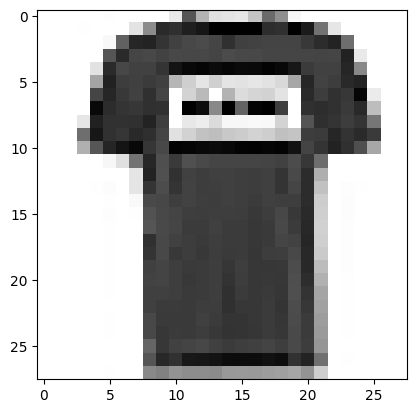

In [10]:
train_example=train_dataset[1][0]
print("Image size is:",train_example.shape)
matplotlib_imshow(train_example,one_channel=True)

### Model

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,5)#shape->[in_channels,out_channels,kernel_size]
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(6,16,5)

        self.fc1=nn.Linear(16*4*4,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self,x):
        #x->[batch_size,channels,height,width]->[4,1,28,28]
        x=F.relu(self.conv1(x))
        x=self.pool(x)
        x=F.relu(self.conv2(x))
        x=self.pool(x)
        # first convolutional layer shape is torch.Size([4, 6, 24, 24])
        # first pooling layer shape is torch.Size([4, 6, 12, 12])
        # second convolutional layer shape is torch.Size([4, 16, 8, 8])
        # second pooling layer shape is torch.Size([4, 16, 4, 4])
        
        x = x.view(-1, 16 * 4 * 4)#x->[4,256]
        x = F.relu(self.fc1(x))#x->[4,120]
        x = F.relu(self.fc2(x))#x->[4,84]
        x = self.fc3(x)

        return x#x->[4,10]
        
        

In [12]:
nn_model=Model()
# nn_model(example)

In [13]:
nn_model.parameters

<bound method Module.parameters of Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)>

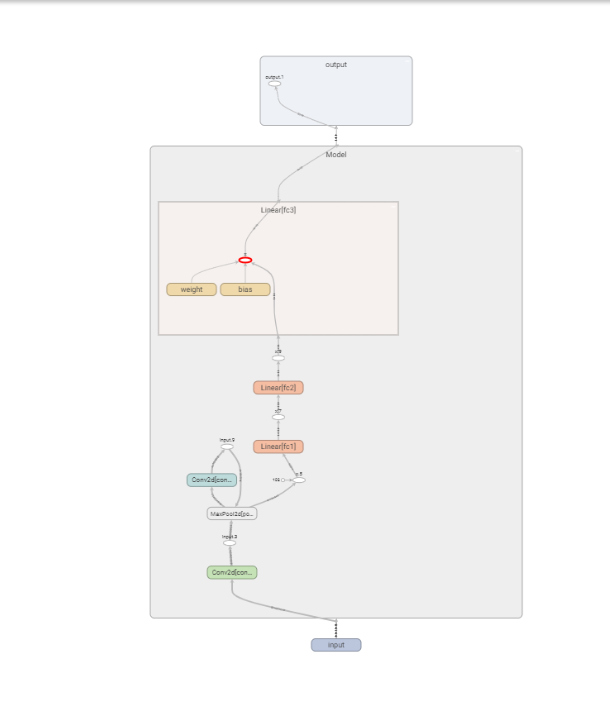

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(nn_model.parameters(),lr=0.001,momentum=0.9)

In [15]:
from torch.utils.tensorboard import SummaryWriter
writer=SummaryWriter('runs/fashion_mnist_experiment_1')

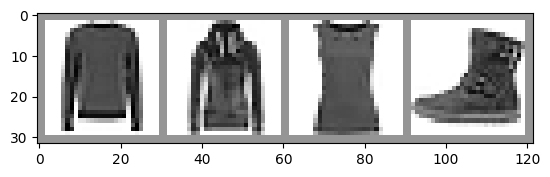

In [16]:
dataiter=iter(train_loader)#generator
images,labels=next(dataiter)
img_grid=torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid,one_channel=True)

In [17]:
writer.add_image('four_fashion_mnist_images', img_grid)

In [18]:
# tensorboard --logdir=runs

In [19]:
writer.add_graph(nn_model,images)
writer.close()

### Projector

In [21]:
def n_random(data,target,n=10):
    assert len(data)==len(target)
    perm=torch.randperm(len(data))
    print(perm)
    return data[perm][:n],target[perm][:n]
images,labels=n_random(train_dataset.data,train_dataset.targets)
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images.unsqueeze(1))
writer.close()


tensor([26124, 32255, 37284,  ..., 52501, 45806, 23539])


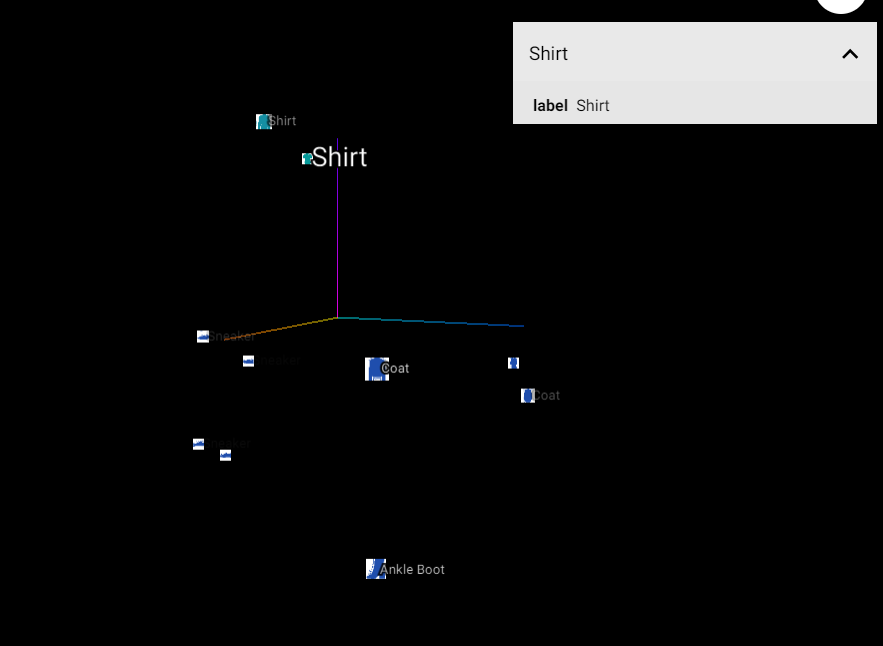

In [23]:
images.shape,labels.shape

(torch.Size([10, 28, 28]), torch.Size([10]))

In [27]:
images.unsqueeze(1).shape

torch.Size([10, 1, 28, 28])

### Model training tracking

In [43]:
def image_to_probs(model,images):
    output=model(images)#->[batch_size,classes(10)]
    _,preds_tensor=torch.max(output,1)#->[batch_size]
    preds = np.squeeze(preds_tensor.numpy())#->[batch_size,]
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

def plot_classes_predictions(model,images,labels):
    preds,prob=image_to_probs(model,images)
    fig=plt.figure(figsize=(12,48))
    for id in np.arange(4):
        ax=fig.add_subplot(1,4,id+1,xticks=[],yticks=[])
        matplotlib_imshow(images[id],one_channel=True)
        ax.set_title("{0},{1:.1f}%\n(label:{2})".format(
            classes[id],prob[id]*100,classes[labels[id]]
        ),color="green" if labels[id].item()==preds[id] else "red")
        return fig

In [60]:
# for i,data in enumerate(train_loader,0):
        
#     img,tar=data
#     preds=nn_model(img)
#     break
# preds

In [37]:
preds.shape

torch.Size([4, 10])

In [44]:
#training
running_loss=0
for epoch in range(1):
    for i,data in enumerate(train_loader,0):
        
        img,tar=data
    
        optimizer.zero_grad()
        preds=nn_model(img)
    
        loss=criterion(preds,tar)
        loss.backward()
        optimizer.step()
    
        running_loss+=loss.item()
    
        if i % 1000 == 999:
            # every 1000 mini-batches...
    
            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(train_loader) + i)
    
            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_predictions(nn_model, img, tar),
                            global_step=epoch * len(train_loader) + i)
            running_loss = 0.0
print('Finished Training')
        
    

Finished Training


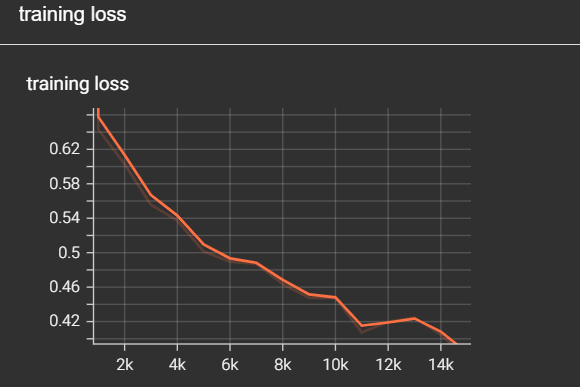

### Evaluation

In [49]:
class_prob=[]
class_labels=[]
with torch.no_grad():
    for data in test_loader:
        img,tar=data
        output=nn_model(img)
        prob_batch=[F.softmax(b,dim=0) for b in output]
        class_prob.append(prob_batch)
        class_labels.append(tar)

        


In [50]:
test_probs = torch.cat([torch.stack(batch) for batch in class_prob])
test_label = torch.cat(class_labels)


In [59]:
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)

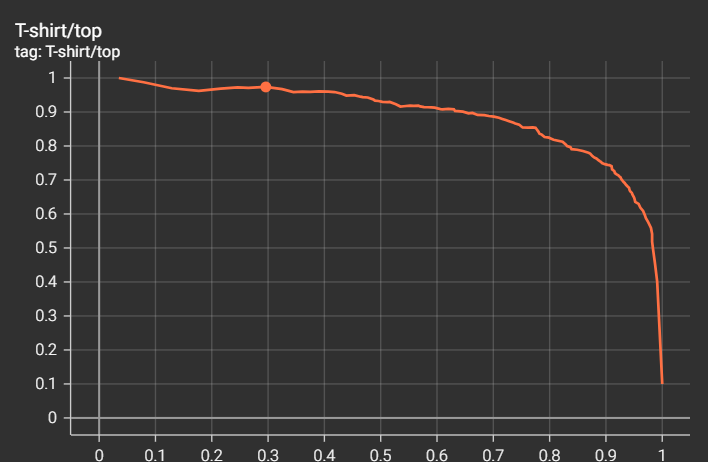 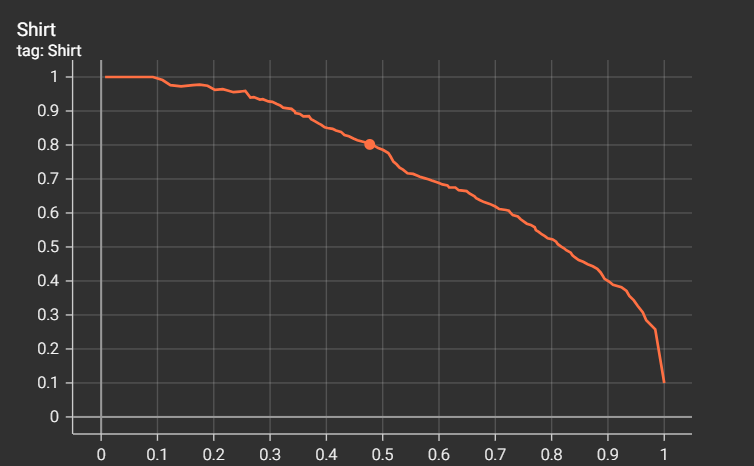